# Credit Card Transactions

This notebook is part of the final project for CYBER207: Applied Machine Learning for Cybersecurity.

**Team Members:**  
Andres Geronimo   
Joshua Penny  
Emma Spradbrow  

## Objective
For this project we chose to improve on an exsiting Kaggle notebook:
https://www.kaggle.com/code/pavankumar4757/credit-card-fraud-detection/input

This notebook contained some procedures that are suspected to have negatively impacted the model.  
The objective of this project is to improve some of those methods, and produce a model that is better at generalization.  

### Notebook contents
This particular notebook includes:
- Data Preprocessing
- Basic Data Analysis.

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Load the dataset
df = pd.read_csv('credit_card_transactions.csv')
df_raw = df.copy()
# Remove 'Unnamed: 0' if it exists
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

In [17]:

# Since we have the Latitude and Longitude of the transactions, we wanted to see
# if there was a primary location where the data was located.
gapminder_df = px.data.gapminder()
fig = px.scatter_geo(lat=df['lat'][df['is_fraud']==1],
                     lon=df['long'][df['is_fraud']==1],
                     title = 'Map of Fraudulent Transactions',
                     scope='usa')
fig.show()


It can been seen that the fraudulent cases are only located in the United States. This is something to keep in mind when training the model if it to be used in locations outside of the United states.

One of the solutions taken to address this, was by calculating the distance between the cardholder and the merchant location. The most computationally efficient way to do this is by using the vectorized Haversine formula.

In [18]:
# ----------------------------
# Data Preprocessing and Feature Engineering
# ----------------------------

# 1. Remove unnecessary features
df.drop(columns=['first', 'last', 'trans_num', 'unix_time', 'street', 'zip', 'merch_zipcode'], inplace=True)

# 2. Convert 'trans_date_trans_time' to datetime and extract features
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek

# 3. Calculate age from 'dob'
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365

# 4. Drop 'dob' and 'trans_date_trans_time' as they are no longer needed
df.drop(columns=['dob', 'trans_date_trans_time'], inplace=True)

# 5. Anonymize 'cc_num' (hashing)
df['cc_num'] = df['cc_num'].astype(str).apply(lambda x: hash(x))

# 6. Calculate transaction count per 'cc_num' (number of transactions per card)
df.sort_values(['cc_num', 'day', 'hour'], inplace=True)
df['transaction_count'] = df.groupby('cc_num').cumcount() + 1

# 7. Calculate distance between cardholder and merchant locations using vectorized Haversine formula
def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 3956  # Radius of Earth in miles
    return c * r

# Use vectorized calculation
df['distance'] = haversine_vectorized(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

# Drop the original latitude and longitude columns
df.drop(columns=['lat', 'long', 'merch_lat', 'merch_long'], inplace=True)

# 8. Handle categorical variables
# Encode 'gender' as binary (just for our computing purposes)
df['gender'] = df['gender'].map({'M': 0, 'F': 1})

# Limit categories for 'category' and 'state' to top N categories to reduce dimensionality
top_n_categories = 10

# Handle 'category'
top_categories = df['category'].value_counts().nlargest(top_n_categories).index
df['category'] = df['category'].where(df['category'].isin(top_categories), other='Other')
df = pd.get_dummies(df, columns=['category'], drop_first=True)

# Handle 'state'
top_states = df['state'].value_counts().nlargest(top_n_categories).index
df['state'] = df['state'].where(df['state'].isin(top_states), other='Other')
df = pd.get_dummies(df, columns=['state'], drop_first=True)

# 9. Drop 'merchant' due to high cardinality
df.drop(columns=['merchant'], inplace=True)

# 10. Handle 'city_pop'
# Bin 'city_pop' into categories
df['city_pop_bin'] = pd.cut(df['city_pop'], bins=[0, 5000, 50000, 100000, 500000, np.inf],
                            labels=['Village', 'Small', 'Medium', 'Large', 'Metropolis'])
# One-hot encode 'city_pop_bin'
df = pd.get_dummies(df, columns=['city_pop_bin'], drop_first=True)
df.drop(columns=['city_pop'], inplace=True)

# 11. Drop 'job' and 'city' to reduce complexity
df.drop(columns=['job', 'city'], inplace=True)

# 12. Prepare the target variable
y = df['is_fraud']
X = df.drop(columns=['is_fraud'])

In [19]:
#Lets take a look at the data now that it's been processed.
display(X.head(20))

,cc_num,amt,gender,hour,day,month,day_of_week,age,transaction_count,distance,...,state_MO,state_NY,state_OH,state_Other,state_PA,state_TX,city_pop_bin_Small,city_pop_bin_Medium,city_pop_bin_Large,city_pop_bin_Metropolis
241484,-9200416068774061832,65.04,0,1,1,5,2,30,1,63.426867,...,False,False,False,True,False,False,True,False,False,False
400152,-9200416068774061832,41.83,0,1,1,7,0,30,2,47.531667,...,False,False,False,True,False,False,True,False,False,False
400177,-9200416068774061832,32.69,0,1,1,7,0,30,3,43.435916,...,False,False,False,True,False,False,True,False,False,False
486722,-9200416068774061832,7.63,0,1,1,8,3,30,4,56.290244,...,False,False,False,True,False,False,True,False,False,False
487154,-9200416068774061832,62.11,0,7,1,8,3,30,5,36.841005,...,False,False,False,True,False,False,True,False,False,False
574914,-9200416068774061832,54.88,0,7,1,9,6,30,6,22.352010,...,False,False,False,True,False,False,True,False,False,False
1240376,-9200416068774061832,67.88,0,11,1,6,0,31,7,51.458344,...,False,False,False,True,False,False,True,False,False,False
103283,-9200416068774061832,46.70,0,13,1,3,4,29,8,34.054049,...,False,False,False,True,False,False,True,False,False,False
401820,-9200416068774061832,7.27,0,13,1,7,0,30,9,59.529405,...,False,False,False,True,False,False,True,False,False,False
575819,-9200416068774061832,2.72,0,13,1,9,6,30,10,22.067983,...,False,False,False,True,False,False,True,False,False,False


Let's look at the features and see if there are
any interesting indicators that the model might use to identify the fraudlent cases

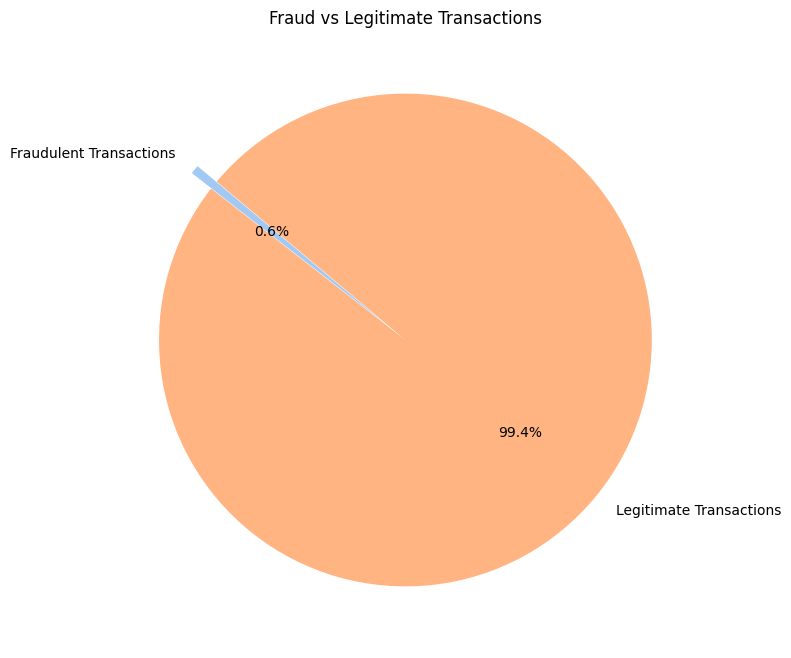

In [20]:
# First lets look at what the model will be trying to identify

#plot the Fraud vs Non-Fraud transactions
plt.figure(figsize=(8, 8))
plt.pie([y.value_counts()[1],
        y.value_counts()[0]],
        labels=['Fraudulent Transactions', 'Legitimate Transactions'],
        autopct='%1.1f%%',
        startangle=140,
        explode = (0.1, 0),  # Slightly separate the Fraudulent slice for emphasis
        colors=sns.color_palette('pastel'))
plt.title('Fraud vs Legitimate Transactions')
plt.show()

It can be seen that the data is heaviliy skewed in favor of the legitmate transactions. This mean that accuracy is not necessarily the best metric to be analysing when determining how well the model is performing. If we had a baseline model that always guesses a transaction is 'Non-Fraud', it will have over 99% accuracy, but have an atrocious recall or f1 score because of it's lack of ability to identify the 'Fraud' case. There are a few strategies that can be implemented to address this imbalance that will be discussed later on.

Additionally, since there are so little 'Fraud' cases in comparison to the Non-Fraud cases, trying to identify patterns by comparing features in the Fraud vs Non-Fraud will be difficult to see. Any graphs below will be comparing features strictly for the fraudulent cases.

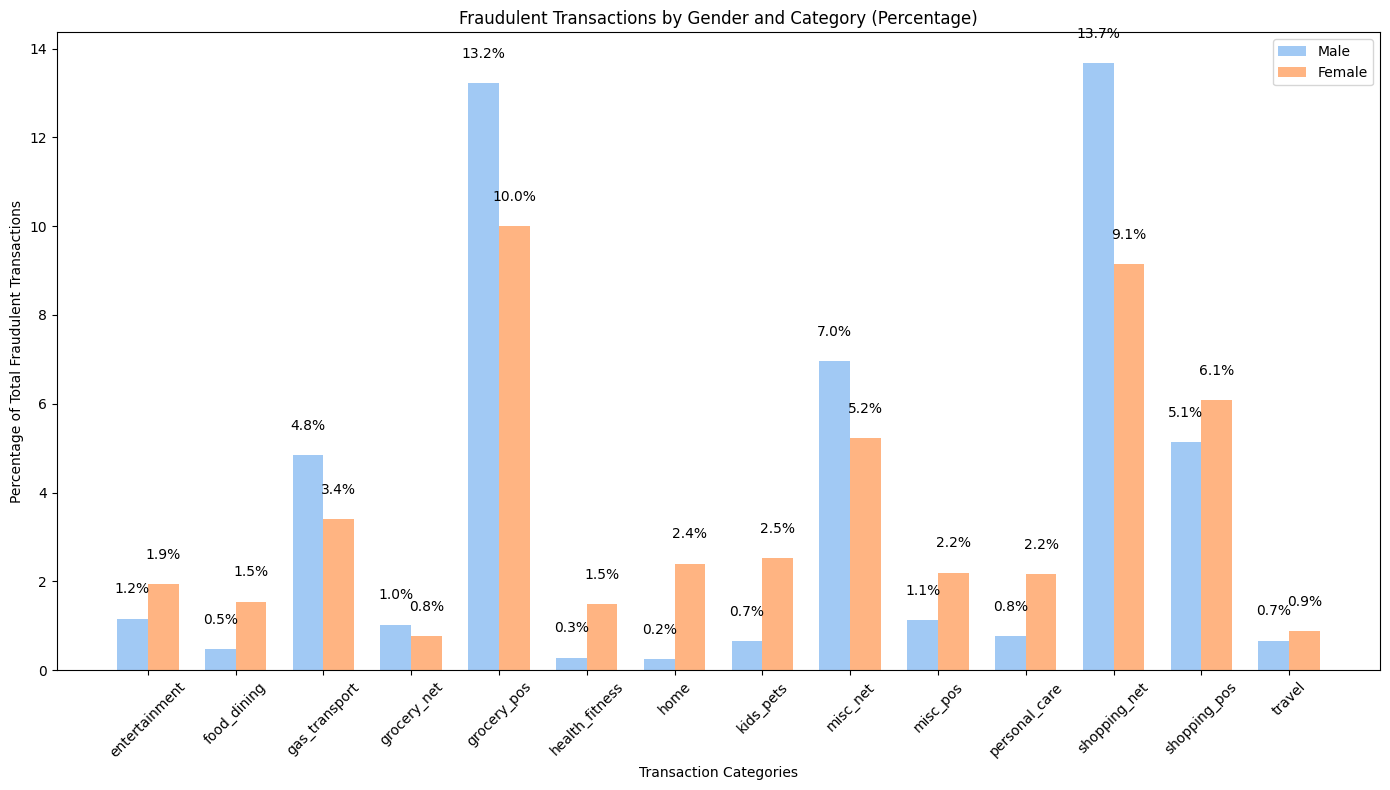

In [21]:
#Show the Fraudulent Transactions by Gender and Category
grouped_data = df_raw.groupby(['is_fraud', 'gender', 'category']).size().reset_index(name='count')
# Filter data to only fraudulent transactions
fraud_data = grouped_data[grouped_data['is_fraud'] == 1]

# Calculate the total number of fraudulent transactions
total_fraudulent_transactions = fraud_data['count'].sum()

# Pivot for fraudulent data
fraud_pivot = fraud_data.pivot_table(index='category', columns='gender', values='count', fill_value=0)

# Calculate percentages
fraud_pivot_percentage = (fraud_pivot / total_fraudulent_transactions) * 100

# Plot side-by-side bars
categories = fraud_pivot_percentage.index
x = range(len(categories))
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(14, 8))

# Plot bars for Male and Female
color_palette =sns.color_palette('pastel', n_colors=2)
bars_male = ax.bar(x, fraud_pivot_percentage.get('M', [0] * len(categories)), width=width, label='Male', color = color_palette[0])
bars_female = ax.bar([i + width for i in x], fraud_pivot_percentage.get('F', [0] * len(categories)), width=width, label='Female', color = color_palette[1])

# Annotate percentages on bars
for bar in bars_male:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

for bar in bars_female:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

# Customize the chart
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(categories, rotation=45)
ax.set_xlabel('Transaction Categories')
ax.set_ylabel('Percentage of Total Fraudulent Transactions')
ax.set_title('Fraudulent Transactions by Gender and Category (Percentage)')

ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

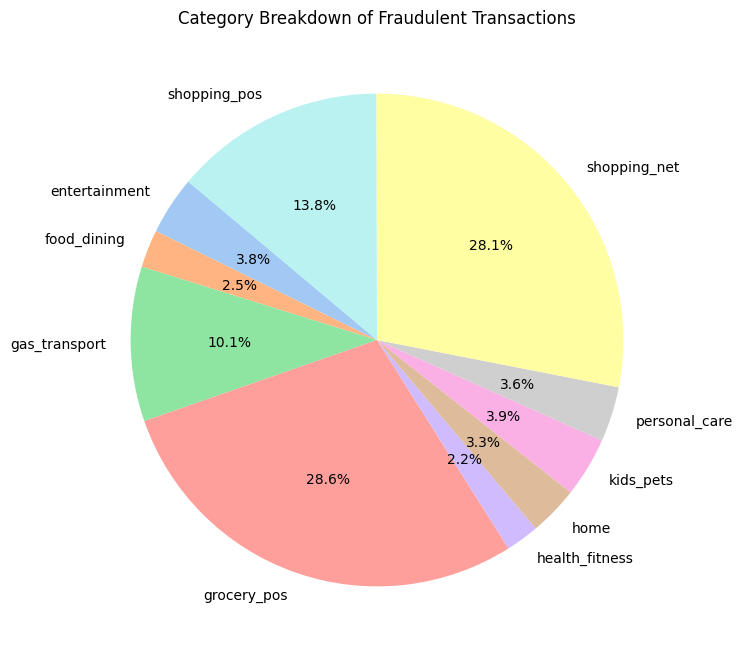

In [22]:
#Pie chart to see the distribution of the top 10 categories of fraudulent transactions
plt.figure(figsize=(14, 8))

# Get the one-hot encoded category columns
category_cols = [col for col in df.columns if col.startswith('category_')]
# Grab the fraudulent transactions and sum across category columns
fraud_category_counts = df[df['is_fraud'] == 1][category_cols].sum()

# Plot the pie chart
plt.pie(fraud_category_counts,
        labels=fraud_category_counts.index.str.replace('category_', ''),  # Remove 'category_' prefix from labels
        autopct='%1.1f%%',
        colors=sns.color_palette("pastel", n_colors=len(fraud_category_counts)),
        startangle=140)
plt.title('Category Breakdown of Fraudulent Transactions')
plt.show()

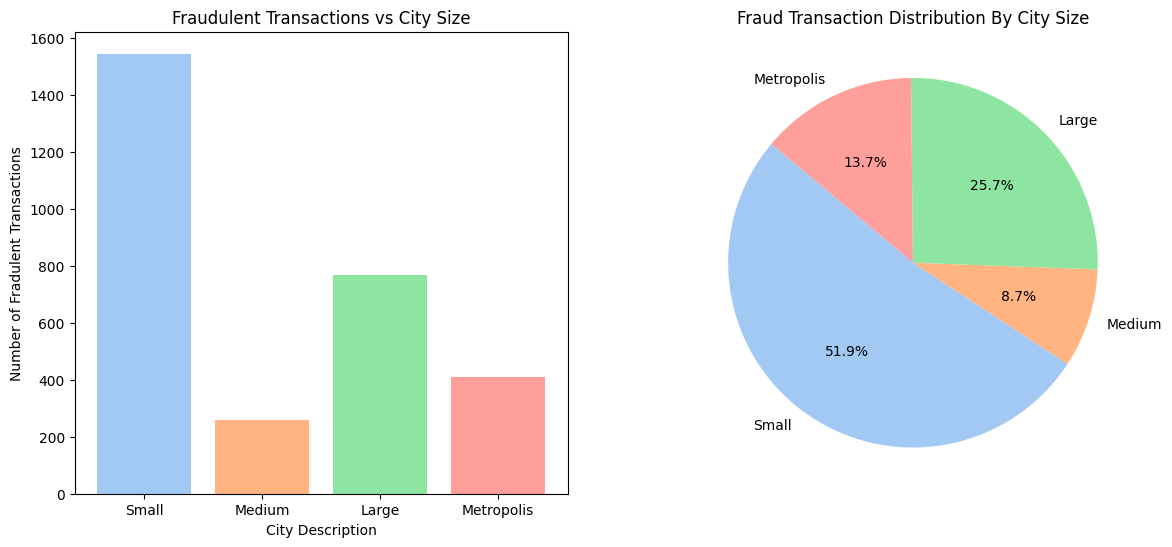

In [23]:
# Display Distribution of fradulent transactions vs city size

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Get the one-hot encoded city_pop_bin columns
city_pop_bin_cols = [col for col in X.columns if col.startswith('city_pop_bin_')]

# Extract the labels from the column names
labels = [col.replace('city_pop_bin_', '') for col in city_pop_bin_cols]
values = df[df['is_fraud'] == 1][city_pop_bin_cols].sum()

#Show a bar graph of the Number of Transactions vs the City Size Indentifier
axes[0].bar(labels, values, color=sns.color_palette('pastel', n_colors=len(labels)))
axes[0].set_title('Fraudulent Transactions vs City Size')
axes[0].set_xlabel('City Description')
axes[0].set_ylabel('Number of Fradulent Transactions')

# Additionally, show as a pie chart to see the percentage of fraud transactions per city size
axes[1].pie(values, labels=labels, autopct='%1.1f%%', colors=sns.color_palette('pastel', n_colors=len(labels)), startangle=140)
axes[1].set_title('Fraud Transaction Distribution By City Size')

plt.show()


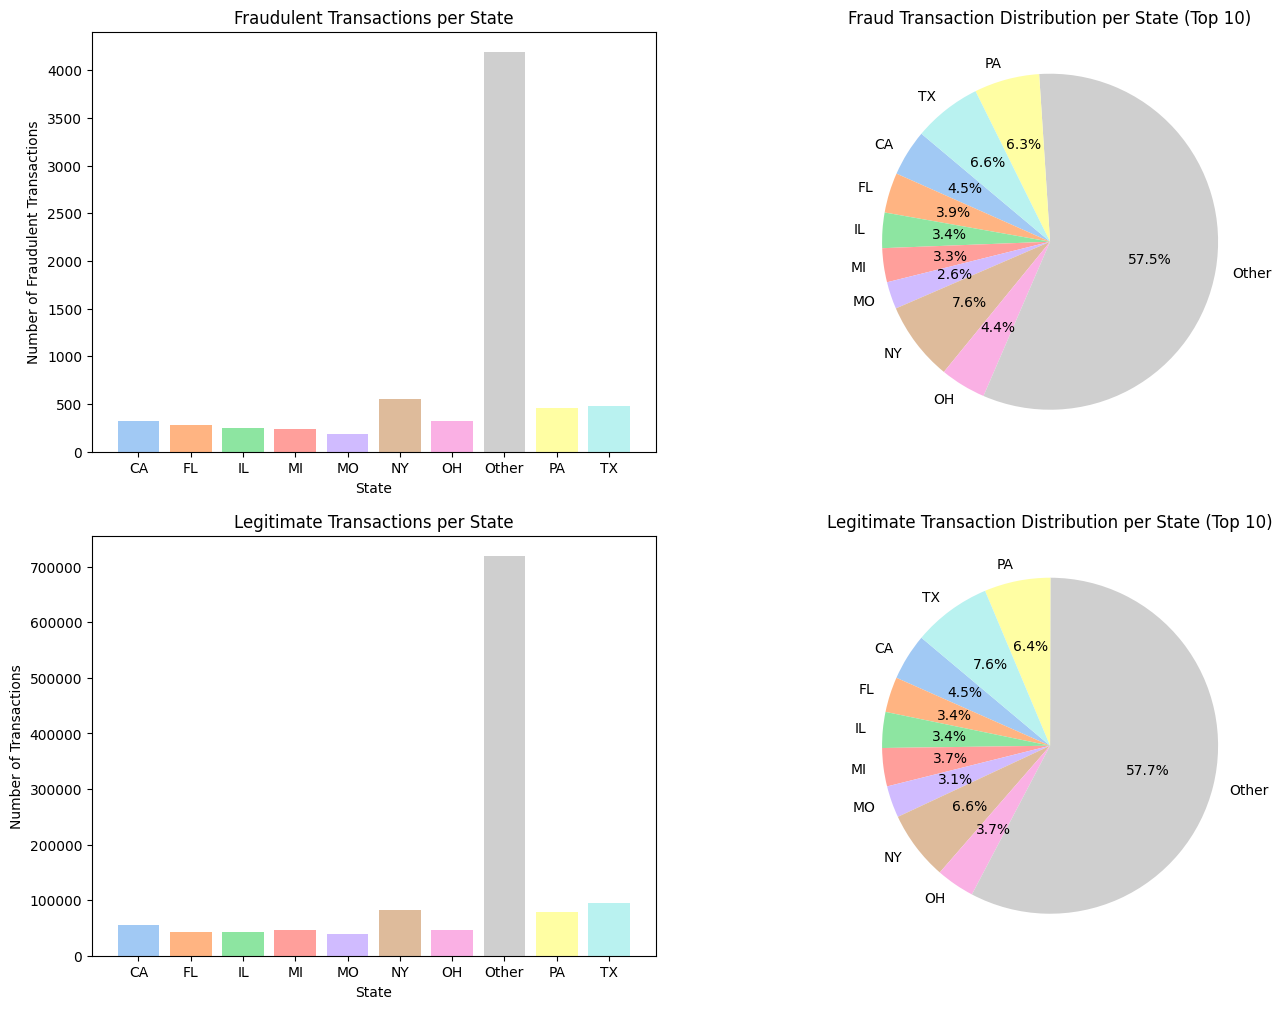

In [24]:
# Plot the Distribution of fradulent transactions per state.
# this will only show the top 9 states with the rest being put in other.
# Also look at the distribution of Legitimate Transaction per state to see if there is a similar
# distribution

fig, axes = plt.subplots(2, 2, figsize=(16,12))

# Access one-hot encoded city_pop_bin columns instead of the original column
state_cols = [col for col in X.columns if col.startswith('state_')]

labels = [col.replace('state_', '') for col in state_cols]  # Extract labels from column names
values = df[df['is_fraud'] == 1][state_cols].sum()

#Show a bar graph of the Number of Fraudulent Transactions Per State, with the states being to top 10
# most common in the dataset
axes[0][0].bar(labels, values, color=sns.color_palette('pastel', n_colors=len(labels)))
axes[0][0].set_title('Fraudulent Transactions per State')
axes[0][0].set_xlabel('State')
axes[0][0].set_ylabel('Number of Fraudulent Transactions')

#Additionally, show an alternative view as a pie chart.
axes[0][1].pie(values, labels=labels, autopct='%1.1f%%', colors=sns.color_palette('pastel', n_colors=len(labels)), startangle=140)
axes[0][1].set_title('Fraud Transaction Distribution per State (Top 10)')

values = df[df['is_fraud'] == 0][state_cols].sum()

#Show a bar graph of the Number of legitimate Transactions Per State, with the states being to top 10
# most common in the dataset
axes[1][0].bar(labels, values, color=sns.color_palette('pastel', n_colors=len(labels)))
axes[1][0].set_title('Legitimate Transactions per State')
axes[1][0].set_xlabel('State')
axes[1][0].set_ylabel('Number of Transactions')

#Additionally, show an alternative view as a pie chart.
axes[1][1].pie(values, labels=labels, autopct='%1.1f%%', colors=sns.color_palette('pastel', n_colors=len(labels)), startangle=140)
axes[1][1].set_title('Legitimate Transaction Distribution per State (Top 10)')

plt.show()

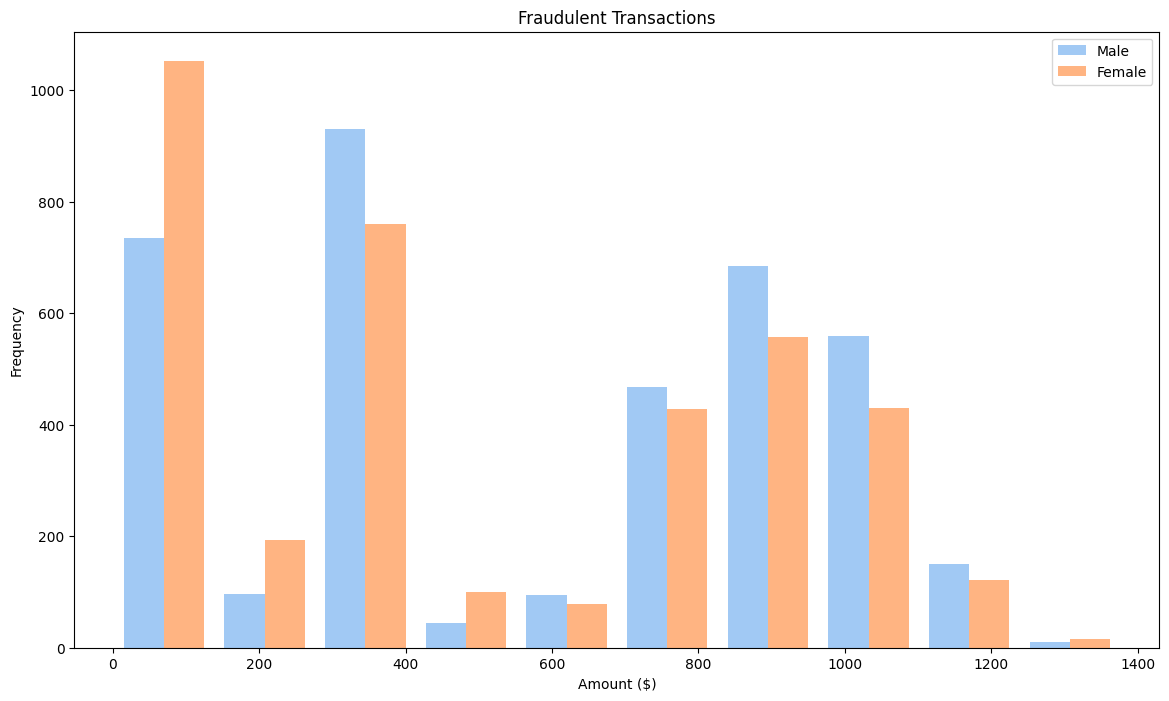

In [25]:
# Show a dsitribution of fraud transactions compared to the amount of those transactions.
# Also compare the fraud transactions to cardholder's gender
plt.figure(figsize=(14,8))
plt.hist( [X['amt'][df['is_fraud']==1][df['gender']==0],
           X['amt'][df['is_fraud']==1][df['gender']==1]],
          bins = 10,
          color=sns.color_palette('pastel', n_colors=2),
          label=['Male', 'Female']
          )
plt.title('Fraudulent Transactions')
plt.legend(['Male', 'Female'])
plt.xlabel('Amount ($)')
plt.ylabel('Frequency')

plt.show()


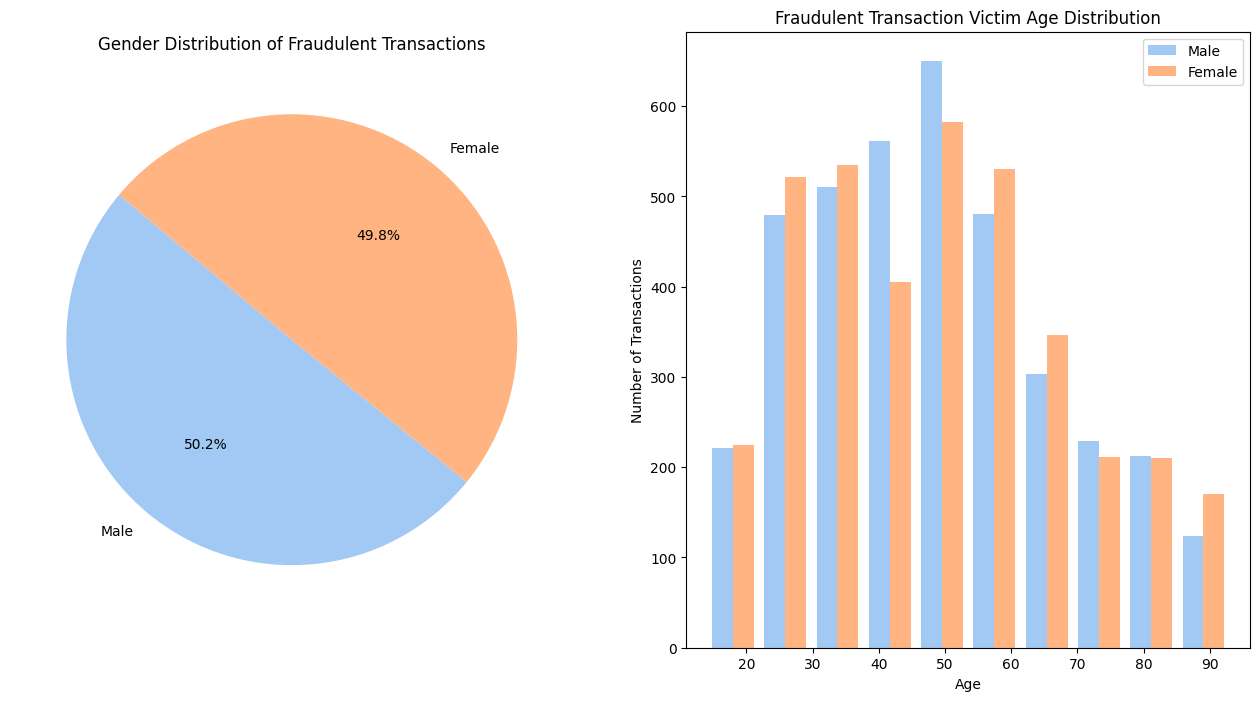

In [26]:
#Plot two graphs, one of a pie chart showing the percentage of Fraudulent transactions
# percentage of male and female. Also show a historgram to show the age distribution
# while also showing the gender between those age groups.

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

male_fraud = len(df[(df['is_fraud']==1)&(X['gender']==0)])
female_fraud = len(df[(df['is_fraud']==1)&(X['gender']==1)])
# Plot the pie chart
axes[0].pie([male_fraud, female_fraud],
        labels=['Male', 'Female'],
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel', n_colors=2),
        startangle=140)
axes[0].set_title('Gender Distribution of Fraudulent Transactions')

#Plot the histogram
axes[1].hist([X['age'][df['is_fraud']==1][X['gender']==0],
          X['age'][df['is_fraud']==1][X['gender']==1]], bins=10, color=sns.color_palette('pastel', n_colors=2))
axes[1].set_title('Fraudulent Transaction Victim Age Distribution')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Number of Transactions')
axes[1].legend(['Male', 'Female'])

plt.show()


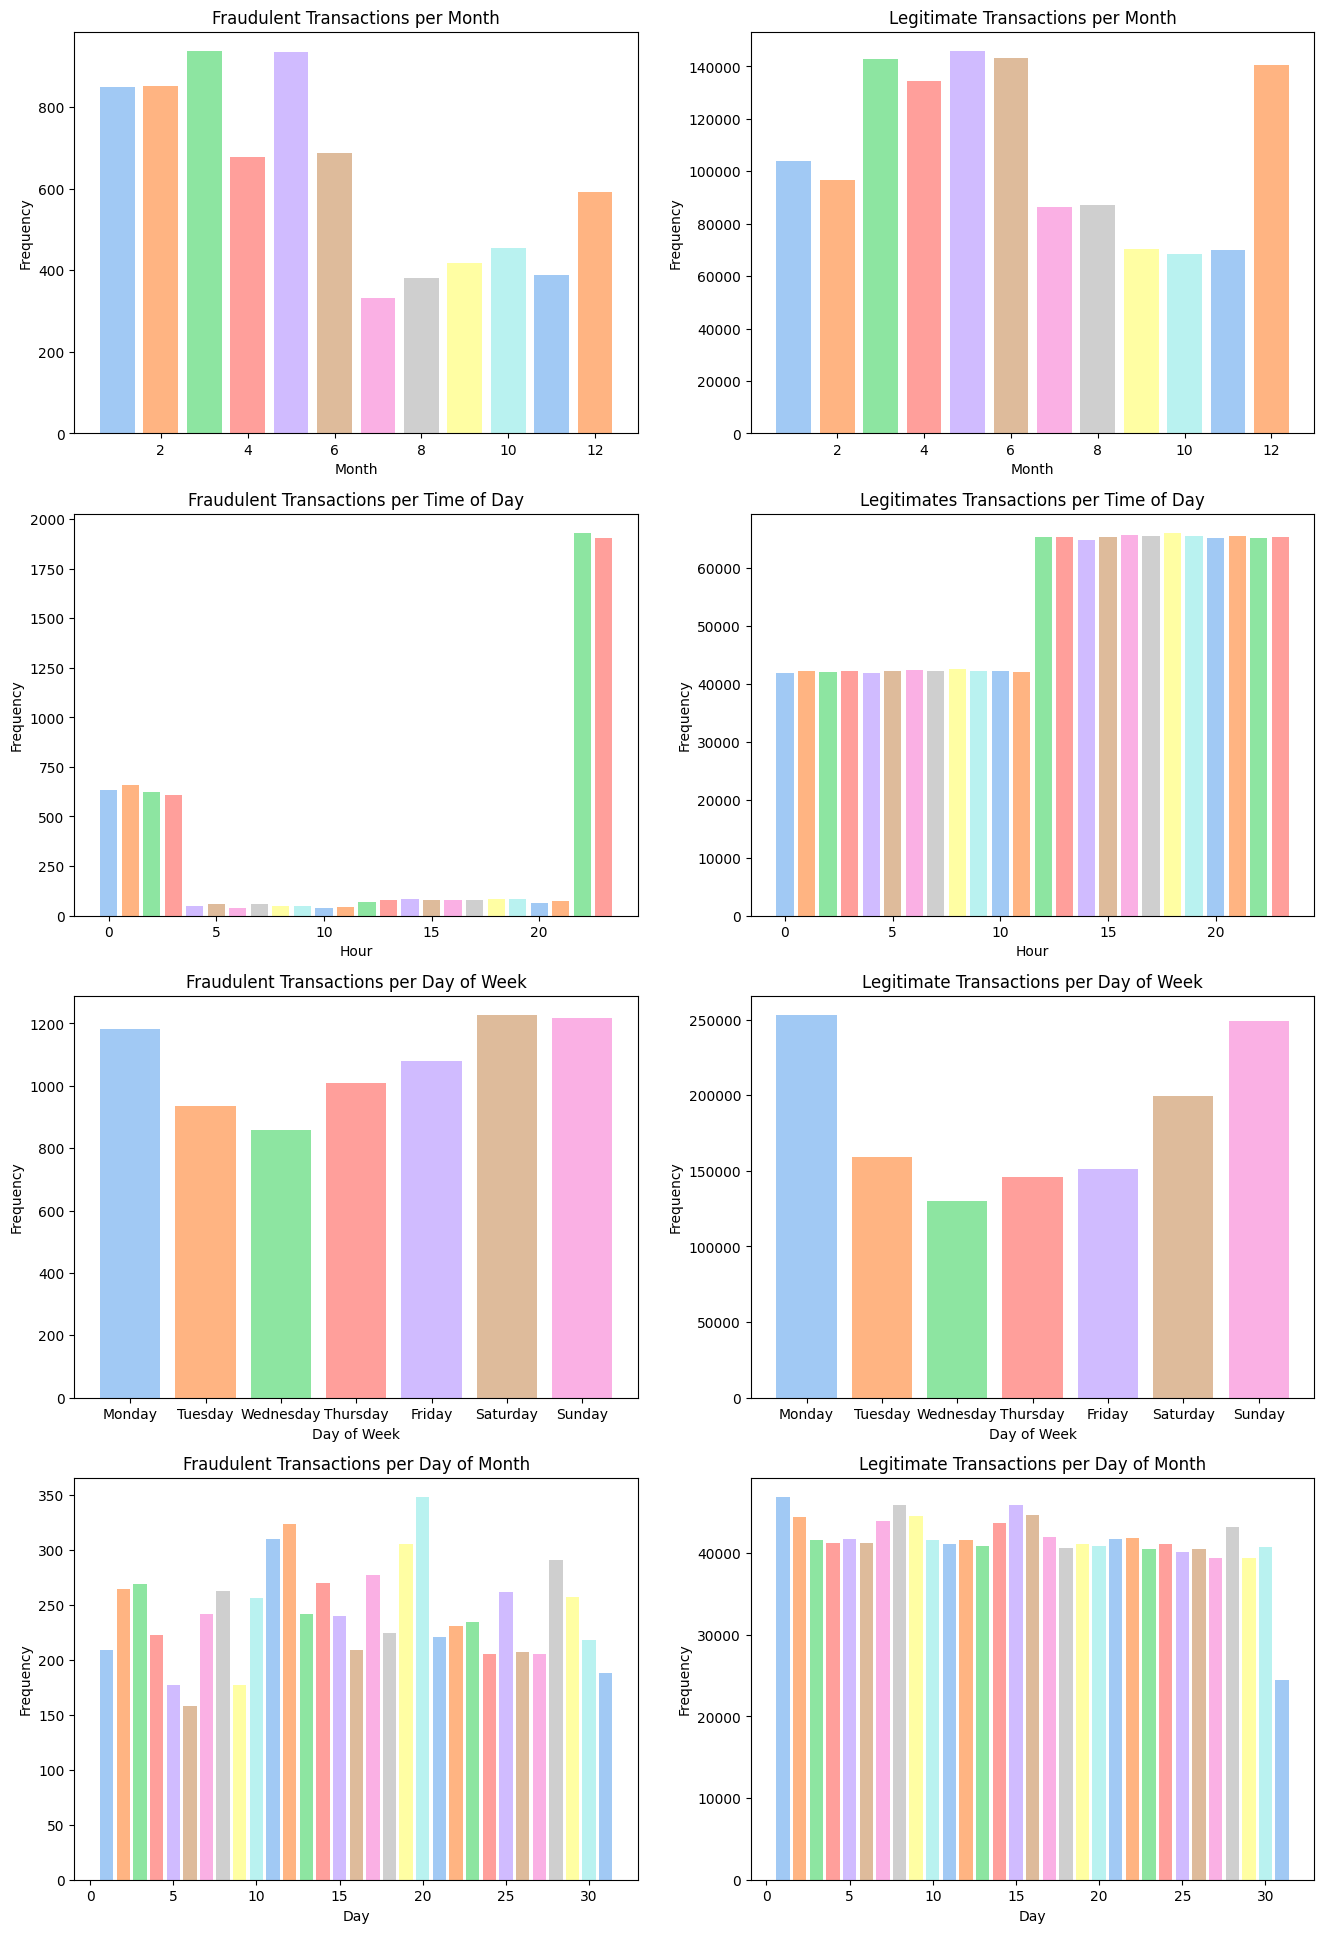

In [27]:
#This code will generate a plot to show if there's any interesting indicators related
# to when the transactions took place.

#This code will generate 8 plots. Plots shown on the left side will be the
# Fraudulent Transaction comparison. The plots shown on the right side, will be
# the Legitimate transactions.

fig, axes = plt.subplots(4,2, figsize=(16,24))

#--------------------------------
#Plot: Transaction Per Month
#--------------------------------
# Plot Fraud Transactions
month_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
vc = X['month'][df['is_fraud']==1].value_counts()
vc = vc.reindex(month_order, fill_value = 0)

axes[0][0].bar(vc.index, vc.values, color=sns.color_palette('pastel', n_colors=12))
axes[0][0].set_title('Fraudulent Transactions per Month')
axes[0][0].set_xlabel('Month')
axes[0][0].set_ylabel('Frequency')

#Plot Legitimate Transactions per month
vc = X['month'][df['is_fraud']==0].value_counts()
vc = vc.reindex(month_order, fill_value = 0)

axes[0][1].bar(vc.index, vc.values, color=sns.color_palette('pastel', n_colors=12))
axes[0][1].set_title('Legitimate Transactions per Month')
axes[0][1].set_xlabel('Month')
axes[0][1].set_ylabel('Frequency')

#--------------------------------
#Plot: Transaction Per Hour of Day
#--------------------------------
#Plot the Fraud Case
vc2 = X['hour'][df['is_fraud']==1].value_counts()
vc2.sort_index(inplace=True)

axes[1][0].bar(vc2.index, vc2.values, color=sns.color_palette('pastel', n_colors=24))
axes[1][0].set_title('Fraudulent Transactions per Time of Day')
axes[1][0].set_xlabel('Hour')
axes[1][0].set_ylabel('Frequency')

#Plot the Legitimate Case
vc2 = X['hour'][df['is_fraud']==0].value_counts()
vc2.sort_index(inplace=True)

axes[1][1].bar(vc2.index, vc2.values, color=sns.color_palette('pastel', n_colors=24))
axes[1][1].set_title('Legitimates Transactions per Time of Day')
axes[1][1].set_xlabel('Hour')
axes[1][1].set_ylabel('Frequency')

#--------------------------------
#Plot: Transaction Per Day of Week
#--------------------------------

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#Plot the Fraud Case
vc3 = X['day_of_week'][df['is_fraud']==1].value_counts()
vc3.sort_index(inplace=True)
vc3.index = weekdays
axes[2][0].bar(vc3.index, vc3.values, color=sns.color_palette('pastel', n_colors=7))
axes[2][0].set_title('Fraudulent Transactions per Day of Week')
axes[2][0].set_xlabel('Day of Week')
axes[2][0].set_ylabel('Frequency')

#Plot the Legitimate Case
vc3 = X['day_of_week'][df['is_fraud']==0].value_counts()
vc3.sort_index(inplace=True)
vc3.index = weekdays
axes[2][1].bar(vc3.index, vc3.values, color=sns.color_palette('pastel', n_colors=7))
axes[2][1].set_title('Legitimate Transactions per Day of Week')
axes[2][1].set_xlabel('Day of Week')
axes[2][1].set_ylabel('Frequency')

#--------------------------------
#Plot: Transaction Per Day of Month
#--------------------------------
#Plot the Fraud Case
vc4 = X['day'][df['is_fraud']==1].value_counts()
vc4.sort_index(inplace=True)
axes[3][0].bar(vc4.index, vc4.values, color=sns.color_palette('pastel', n_colors=31))
axes[3][0].set_title('Fraudulent Transactions per Day of Month')
axes[3][0].set_xlabel('Day')
axes[3][0].set_ylabel('Frequency')

#Plot the Legitimate Case
vc4 = X['day'][df['is_fraud']==0].value_counts()
vc4.sort_index(inplace=True)
axes[3][1].bar(vc4.index, vc4.values, color=sns.color_palette('pastel', n_colors=31))
axes[3][1].set_title('Legitimate Transactions per Day of Month')
axes[3][1].set_xlabel('Day')
axes[3][1].set_ylabel('Frequency')



#Display all the plots.
plt.show()


One interesting take away could be that a large portion of the fraudulent transactions occur between 11:00pm and 3:00 am. This is something the model could recognize, and it's something to keep in mind to ensure the model doesn't overfit.

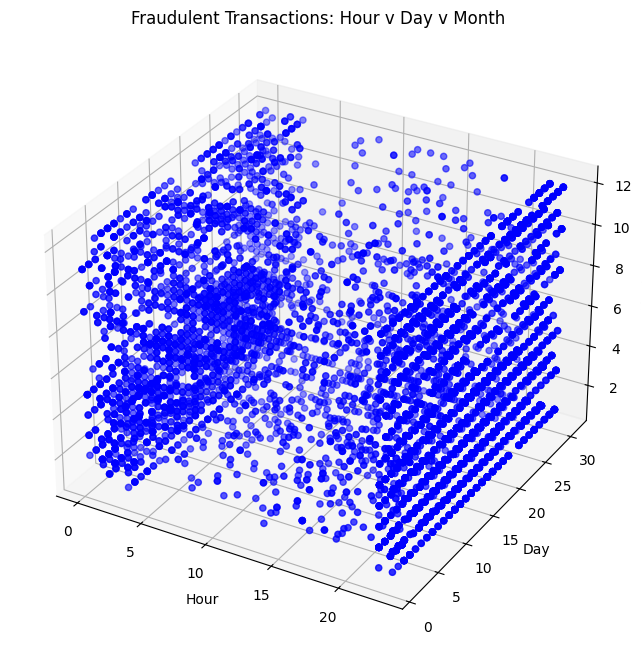

In [28]:
# Display an alternative 3d map of fraudulent cases by Hour, Day and Month
plt.figure(figsize=(14,8))
ax = plt.axes(projection='3d')
ax.set_zlabel('Month')
ax.set_xlabel('Hour')
ax.set_ylabel('Day')

ax.set_title('Fraudulent Transactions: Hour v Day v Month')

ax.scatter3D(
          X['hour'][df['is_fraud']==1],
          X['day'][df['is_fraud']==1],
          X['month'][df['is_fraud']==1],
          color='blue' ,
          marker='o',
          label='Fraud'
          )

plt.show()